In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [5]:
acc_df = pd.read_csv("../eval/fit_ranges/acc_ref_df.csv")

filenames = ["split_1.csv","split_2.csv","split_3.csv","split_4.csv"]

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(f"../eval/quantifications/ranges/range_{filename}"))
df =pd.concat(dfs,sort=False)

acc_df = acc_df[acc_df["filename"].isin(list(df["filename"].unique()))]
ref_df = pd.read_csv("../pre_results/full_ref_df.csv")

c_df = pd.merge(df,ref_df,on="filename",suffixes=("","_full"))
c_df = pd.merge(c_df,acc_df,on="filename",suffixes=("_model","_acc"))

df["model"]="model"
ref_df["model"]="full"
acc_df["model"]="acc"
df = pd.concat([df,ref_df,acc_df],sort=False)

c_df["gaba_conc_cr_model_error"] = c_df["gaba_conc_cr_model"]-c_df["gaba_conc_cr_full"]
c_df["gaba_conc_cr_model_abs_error"] = abs(c_df["gaba_conc_cr_model_error"])
c_df["gaba_conc_water_model_error"] = c_df["gaba_conc_water_model"]-c_df["gaba_conc_water_full"]
c_df["gaba_conc_water_model_abs_error"] = abs(c_df["gaba_conc_water_model_error"])

c_df["gaba_conc_cr_acc_error"] = c_df["gaba_conc_cr_acc"]-c_df["gaba_conc_cr_full"]
c_df["gaba_conc_cr_acc_abs_error"] = abs(c_df["gaba_conc_cr_acc_error"])
c_df["gaba_conc_water_acc_error"] = c_df["gaba_conc_water_acc"]-c_df["gaba_conc_water_full"]
c_df["gaba_conc_water_acc_abs_error"] = abs(c_df["gaba_conc_water_acc_error"])

c_df["gaba_conc_cr_model_rel_error"] = c_df["gaba_conc_cr_model_error"]/c_df["gaba_conc_cr_full"]
c_df["gaba_conc_cr_acc_rel_error"] = c_df["gaba_conc_cr_acc_error"]/c_df["gaba_conc_cr_full"]
c_df["gaba_conc_cr_model_rel_abs_error"] = c_df["gaba_conc_cr_model_abs_error"]/c_df["gaba_conc_cr_full"]
c_df["gaba_conc_cr_acc_rel_abs_error"] = c_df["gaba_conc_cr_acc_abs_error"]/c_df["gaba_conc_cr_full"]


In [6]:
### coeficient of variation of many metrics ---
i_df = c_df.copy()

metrics = [("gaba_conc_cr_model","gaba_conc_cr_acc"),("gaba_conc_cr_model_abs_error","gaba_conc_cr_acc_abs_error"),
           ("gaba_conc_cr_model_rel_abs_error","gaba_conc_cr_acc_rel_abs_error"),
           ("gaba_snr_model","gaba_snr_acc"),("gaba_fit_error_model","gaba_fit_error_acc")]

for metric_mod,metric_acc in metrics:
    i_df = c_df.copy()
    i_df[f"{metric_mod}_std"]=i_df[metric_mod]
    i_df[f"{metric_acc}_std"]=i_df[metric_acc]

    i_df = i_df.groupby("filename").agg({metric_mod:"mean",f"{metric_mod}_std":"std",
                                        metric_acc:"mean",f"{metric_acc}_std":"std"})
    i_df["cv_model"]=i_df[f"{metric_mod}_std"]/i_df[metric_mod]
    i_df["cv_acc"]=i_df[f"{metric_acc}_std"]/i_df[metric_acc]
    print(metric_mod)
    print(f"Model CV: {i_df['cv_model'].mean():.3f} +/- {i_df['cv_model'].std():.3f}")
    print(f"Acc CV: {i_df['cv_acc'].mean():.3f} +/- {i_df['cv_acc'].std():.3f}")
    print(f"wilcoxon p-value: {st.wilcoxon(i_df['cv_model'],i_df['cv_acc']).pvalue:.4f}")
    print("-------------")

gaba_conc_cr_model
Model CV: 0.340 +/- 0.424
Acc CV: 0.210 +/- 0.623
wilcoxon p-value: 0.0269
-------------
gaba_conc_cr_model_abs_error
Model CV: 0.720 +/- 0.412
Acc CV: 0.844 +/- 0.599
wilcoxon p-value: 0.1097
-------------
gaba_conc_cr_model_rel_abs_error
Model CV: 0.720 +/- 0.412
Acc CV: 0.844 +/- 0.599
wilcoxon p-value: 0.1097
-------------
gaba_snr_model
Model CV: 0.386 +/- 0.763
Acc CV: 0.185 +/- 0.257
wilcoxon p-value: nan
-------------
gaba_fit_error_model
Model CV: 0.292 +/- 0.133
Acc CV: 0.233 +/- 0.493
wilcoxon p-value: 0.0000
-------------


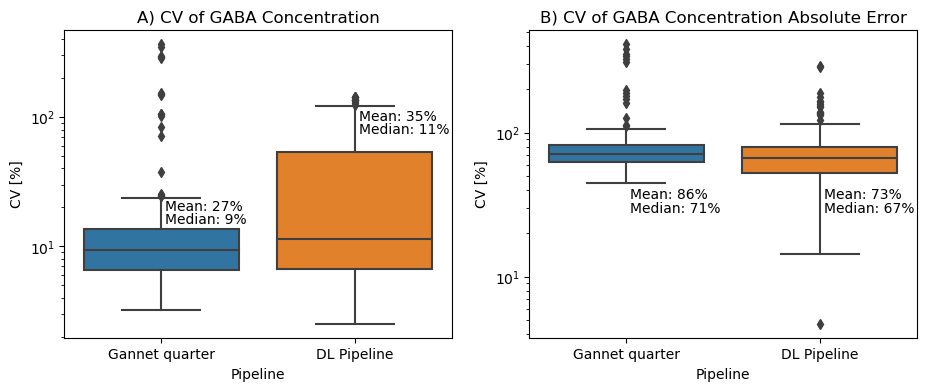

In [99]:
###boxplot of metrics for each?
i_df = df[df["model"].isin(["model","acc"])].copy()

i_df["model"]=i_df.apply(lambda x: "DL Pipeline" if x["model"]=="model" else "Gannet quarter",axis=1)

i_df = pd.merge(i_df,ref_df,on=["filename"],suffixes=("","_full"))
i_df["gaba_conc_cr_abs_error"] = abs(i_df["gaba_conc_cr"]-i_df["gaba_conc_cr_full"])
i_df["gaba_conc_cr_rel_error"] = i_df["gaba_conc_cr_abs_error"]/i_df["gaba_conc_cr_full"]

i_df["mean_conc"] = i_df["gaba_conc_cr"]
i_df["std_conc"] = i_df["gaba_conc_cr"]
i_df["mean_error"] = i_df["gaba_conc_cr_abs_error"]
i_df["std_error"] = i_df["gaba_conc_cr_abs_error"]

ii_df = i_df.groupby(["filename","model"]).agg({"mean_conc":"mean","std_conc":"std","mean_error":"mean","std_error":"std"}).reset_index()
ii_df = ii_df.sort_values("model",ascending=False)
ii_df["conc_cv"] = ii_df["std_conc"]/abs(ii_df["mean_conc"])*100
ii_df["error_cv"] = ii_df["std_error"]/ii_df["mean_error"]*100


fig,ax = plt.subplots(1,2,figsize=(11,4))

sns.boxplot(data=ii_df,ax=ax[0],x="model",y="conc_cv")

sns.boxplot(data=ii_df,ax=ax[1],x="model",y="error_cv")

for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_ylabel("CV [%]")
    ax[i].set_xlabel("Pipeline")

ax[0].set_title("A) CV of GABA Concentration")
ax[1].set_title("B) CV of GABA Concentration Absolute Error")

i_mod_df = ii_df[ii_df["model"]=="DL Pipeline"]
i_acc_df = ii_df[ii_df["model"]=="Gannet quarter"]

### check wilcoxon
if False:
    print(st.wilcoxon(i_mod_df["conc_cv"],i_acc_df["conc_cv"]).pvalue)
    print(st.wilcoxon(i_mod_df["error_cv"],i_acc_df["error_cv"]).pvalue)
    print("----")
    print(i_acc_df["conc_cv"].mean())
    print(i_mod_df["conc_cv"].mean())

    print("=")
    print(i_acc_df["conc_cv"].median())
    print(i_mod_df["conc_cv"].median())
    print("----")
    print(i_acc_df["error_cv"].mean())
    print(i_mod_df["error_cv"].mean())

    print("=")
    print(i_acc_df["error_cv"].median())
    print(i_mod_df["error_cv"].median())


ax[0].annotate(f"Mean: {i_acc_df['conc_cv'].mean():.0f}%",(0.02,19))
ax[0].annotate(f"Median: {i_acc_df['conc_cv'].median():.0f}%",(0.02,15))
ax[0].annotate(f"Mean: {i_mod_df['conc_cv'].mean():.0f}%",(1.02,95))
ax[0].annotate(f"Median: {i_mod_df['conc_cv'].median():.0f}%",(1.02,75))

ax[1].annotate(f"Mean: {i_acc_df['error_cv'].mean():.0f}%",(0.02,35))
ax[1].annotate(f"Median: {i_acc_df['error_cv'].median():.0f}%",(0.02,28))
ax[1].annotate(f"Mean: {i_mod_df['error_cv'].mean():.0f}%",(1.02,35))
ax[1].annotate(f"Median: {i_mod_df['error_cv'].median():.0f}%",(1.02,28))

plt.show()

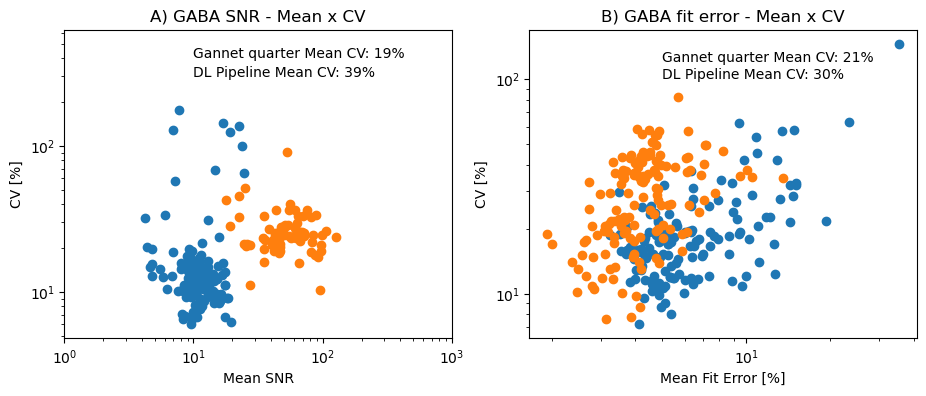

In [143]:
###boxplot of metrics for each?
i_df = df[df["model"].isin(["model","acc"])].copy()
i_df["gaba_fit_error"]=abs(i_df["gaba_fit_error"])
#i_df = i_df[i_df["gaba_snr"]<100000000000]

i_df["model"]=i_df.apply(lambda x: "DL Pipeline" if x["model"]=="model" else "Gannet quarter",axis=1)

i_df = pd.merge(i_df,ref_df,on=["filename"],suffixes=("","_full"))

i_df["mean_snr"] = i_df["gaba_snr"]
i_df["std_snr"] = i_df["gaba_snr"]
i_df["mean_error"] = i_df["gaba_fit_error"]
i_df["std_error"] = i_df["gaba_fit_error"]

ii_df = i_df.groupby(["filename","model"]).agg({"mean_snr":"mean","std_snr":"std","mean_error":"mean","std_error":"std"}).reset_index()
ii_df = ii_df.sort_values("model",ascending=False)
ii_df["snr_cv"] = ii_df["std_snr"]/abs(ii_df["mean_snr"])*100
ii_df["error_cv"] = ii_df["std_error"]/abs(ii_df["mean_error"])*100

i_mod_df = ii_df[ii_df["model"]=="DL Pipeline"]
i_acc_df = ii_df[ii_df["model"]=="Gannet quarter"]

fig,ax = plt.subplots(1,2,figsize=(11,4))

ax[0].scatter(i_acc_df["mean_snr"],i_acc_df["snr_cv"],label="Gannet quarter")
ax[0].scatter(i_mod_df["mean_snr"],i_mod_df["snr_cv"],label="DL Pipeline")

ax[1].scatter(i_acc_df["mean_error"],i_acc_df["error_cv"],label="Gannet quarter")
ax[1].scatter(i_mod_df["mean_error"],i_mod_df["error_cv"],label="DL Pipeline")

for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_ylabel("CV [%]")

ax[0].set_xlabel("Mean SNR")
ax[1].set_xlabel("Mean Fit Error [%]")

ax[0].set_xlim(1,1000)
#ax[0].set_ylim(0,200)
ax[0].set_xscale("log")
ax[1].set_xscale("log")

ax[0].set_title("A) GABA SNR - Mean x CV")
ax[1].set_title("B) GABA fit error - Mean x CV")

ax[0].annotate(f"Gannet quarter Mean CV: {i_acc_df['snr_cv'].mean():.0f}%",(10,400))
ax[0].annotate(f"DL Pipeline Mean CV: {i_mod_df['snr_cv'].mean():.0f}%",(10,300))

ax[1].annotate(f"Gannet quarter Mean CV: {i_acc_df['error_cv'].mean():.0f}%",(5,120))
ax[1].annotate(f"DL Pipeline Mean CV: {i_mod_df['error_cv'].mean():.0f}%",(5,100))

plt.show()

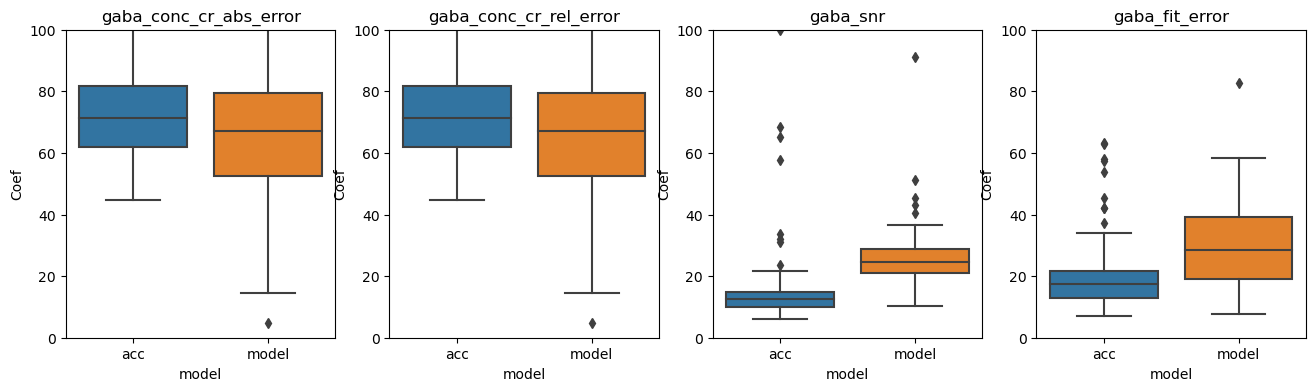

In [59]:
###boxplot of metrics for each?
i_df = df[df["model"].isin(["model","acc"])].copy()

i_df = pd.merge(i_df,ref_df,on=["filename"],suffixes=("","_full"))
i_df["gaba_conc_cr_abs_error"] = abs(i_df["gaba_conc_cr"]-i_df["gaba_conc_cr_full"])
i_df["gaba_conc_cr_rel_error"] = i_df["gaba_conc_cr_abs_error"]/i_df["gaba_conc_cr_full"]

metrics = ["gaba_conc_cr_abs_error","gaba_conc_cr_rel_error","gaba_snr","gaba_fit_error"]

fig,ax = plt.subplots(1,len(metrics),figsize=(len(metrics)*4,4))

for i in range(len(metrics)):
    ii_df = i_df.copy()
    ii_df["mean"]=ii_df[metrics[i]]
    ii_df["std"]=ii_df[metrics[i]]
    ii_df = ii_df.groupby(["filename","model"]).agg({"mean":"mean","std":"std"}).reset_index()
    ii_df["metric"]=ii_df["std"]/ii_df["mean"]*100
    sns.boxplot(data=ii_df,x="model",y="metric",ax=ax[i])
    ax[i].set_ylabel("Coef")
    ax[i].set_title(metrics[i])
    ax[i].set_ylim(0,100)

plt.show()



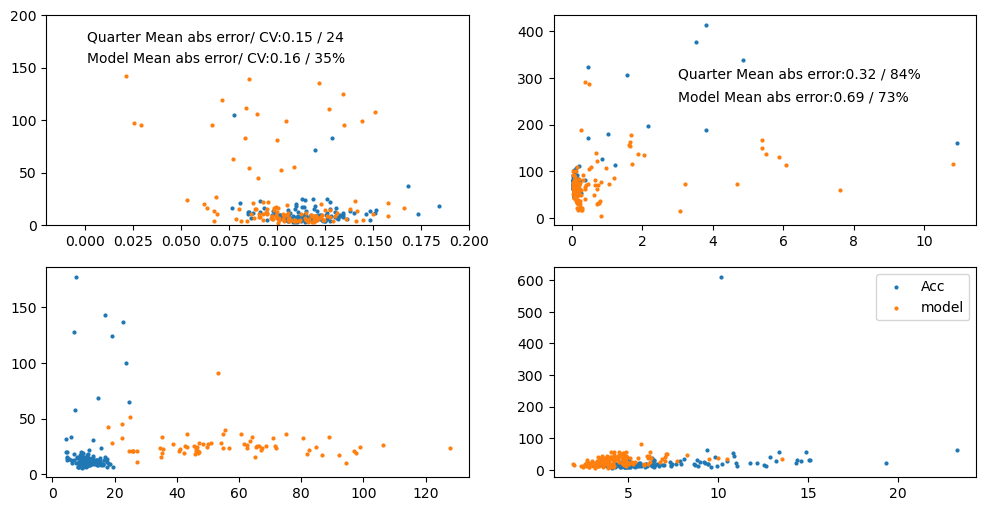

In [57]:
###scatterplots for each of metrics for each?
i_df = df[df["model"].isin(["model","acc"])].copy()

i_df = pd.merge(i_df,ref_df,on=["filename"],suffixes=("","_full"))
i_df["gaba_conc_cr_abs_error"] = abs(i_df["gaba_conc_cr"]-i_df["gaba_conc_cr_full"])
i_df["gaba_conc_cr_rel_error"] = i_df["gaba_conc_cr_abs_error"]/i_df["gaba_conc_cr_full"]

metrics = ["gaba_conc_cr","gaba_conc_cr_rel_error","gaba_snr","gaba_fit_error"]

fig,ax = plt.subplots(2,2,figsize=(12,6))

metric_dicts={"model":{},"acc":{}}

for i in range(len(metrics)):
    ii_df = i_df.copy()

   


    ii_df["mean"]=ii_df[metrics[i]]
    ii_df["std"]=ii_df[metrics[i]]
    ii_df = ii_df.groupby(["filename","model"]).agg({"mean":"mean","std":"std"}).reset_index()

    #extra filtering:
    if i==0:
        ii_df = ii_df[ii_df["mean"]>0]
    elif i==1:
        ii_df = ii_df[ii_df["mean"]<25]
    elif i==2:
        ii_df = ii_df[ii_df["mean"]<10000]    

    ii_mod_df = ii_df[ii_df["model"]=="model"]
    ii_acc_df = ii_df[ii_df["model"]=="acc"]
    ax[i//2,i%2].scatter(ii_acc_df["mean"],ii_acc_df["std"]/ii_acc_df["mean"]*100,label="Acc",s=4)
    ax[i//2,i%2].scatter(ii_mod_df["mean"],ii_mod_df["std"]/ii_mod_df["mean"]*100,label="model",s=4)

    metric_dicts["model"][metrics[i]]={"mean":ii_mod_df["mean"].mean(),"cv":(ii_mod_df["std"]/ii_mod_df["mean"]*100).mean()}
    metric_dicts["acc"][metrics[i]]={"mean":ii_acc_df["mean"].mean(),"cv":(ii_acc_df["std"]/ii_acc_df["mean"]*100).mean()}




ax[0,0].set_xlim(-0.02,0.2)
ax[0,0].set_ylim(0,200)

#ax[0,1].set_xlim(0,0.3)
#ax[0,1].set_ylim(0,200)

#ax[1,0].set_xlim(0,100)
#ax[1,0].set_ylim(0,200)

#ax[1,1].set_xlim(0,20)
#ax[1,1].set_ylim(0,100)

ax[0,0].annotate(f"Quarter Mean abs error/ CV:{metric_dicts['acc']['gaba_conc_cr']['mean']:.2f} / {metric_dicts['acc']['gaba_conc_cr']['cv']:.0f}",(0.001,175))
#ax[0,0].annotate(f"Quarter Mean CV abs error:{metric_dicts['acc']['gaba_conc_cr']['cv']:.0f}%",(0.001,165))
ax[0,0].annotate(f"Model Mean abs error/ CV:{metric_dicts['model']['gaba_conc_cr']['mean']:.2f} / {metric_dicts['model']['gaba_conc_cr']['cv']:.0f}%",(0.001,155))
#ax[0,0].annotate(f"Model Mean CV abs error:{metric_dicts['model']['gaba_conc_cr']['cv']:.0f}%",(0.001,145))

ax[0,1].annotate(f"Quarter Mean relative error / CV:{metric_dicts['acc']['gaba_conc_cr_rel_error']['mean']:.2f} / {metric_dicts['acc']['gaba_conc_cr_rel_error']['cv']:.0f}%",(3,300))
#ax[0,1].annotate(f"Quarter Mean CV abs error:{metric_dicts['acc']['gaba_conc_cr_rel_error']['cv']:.0f}%",(3,250))
#ax[0,1].annotate(f"Model Mean abs error:{metric_dicts['model']['gaba_conc_cr_rel_error']['mean']:.0f}%",(0.001,155))
#

ax[0,1].annotate(f"Model Mean relative error / CV:{metric_dicts['model']['gaba_conc_cr_rel_error']['mean']:.2f} / {metric_dicts['model']['gaba_conc_cr_rel_error']['cv']:.0f}%",(3,250))

# ax[0,1].annotate(f"Model Mean CV abs error:{metric_dicts['model']['gaba_conc_cr_rel_error']['cv']:.0f}%",(0.001,145))

ax[1,0].annotate(f"Model Mean relative error / CV:{metric_dicts['model']['gaba_conc_cr_rel_error']['mean']:.2f} / {metric_dicts['model']['gaba_conc_cr_rel_error']['cv']:.0f}%",(3,250))




plt.legend()
plt.show()

In [7]:
#### coeficient of variation comparison -table

i_df = c_df.copy()
i_df["gaba_conc_cr_model_abs_error_std"] = i_df["gaba_conc_cr_model_abs_error"]
i_df["gaba_conc_cr_acc_abs_error_std"] = i_df["gaba_conc_cr_acc_abs_error"]

i_df = i_df.groupby("filename").agg({"gaba_conc_cr_model_abs_error":"mean","gaba_conc_cr_model_abs_error_std":"std",
                                     "gaba_conc_cr_acc_abs_error":"mean","gaba_conc_cr_acc_abs_error_std":"std"})
i_df["cv_model"]=i_df["gaba_conc_cr_model_abs_error_std"]/i_df["gaba_conc_cr_model_abs_error"]
i_df["cv_acc"]=i_df["gaba_conc_cr_acc_abs_error_std"]/i_df["gaba_conc_cr_acc_abs_error"]

print(f"Model CV: {i_df['cv_model'].mean():.3f} +/- {i_df['cv_model'].std():.3f}")
print(f"Acc CV: {i_df['cv_acc'].mean():.3f} +/- {i_df['cv_acc'].std():.3f}")
print(f"wilcoxon p-value: {st.wilcoxon(i_df['cv_model'],i_df['cv_acc']).pvalue:.4f}")


Model CV: 0.720 +/- 0.412
Acc CV: 0.844 +/- 0.599
wilcoxon p-value: 0.1097


0.10972461414437688


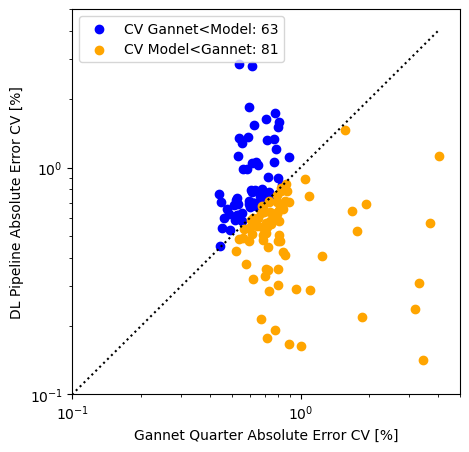

In [145]:
#### coeficient of variation comparison - scatter plot

i_df = c_df.copy()
i_df["gaba_conc_cr_model_abs_error_std"] = i_df["gaba_conc_cr_model_abs_error"]
i_df["gaba_conc_cr_acc_abs_error_std"] = i_df["gaba_conc_cr_acc_abs_error"]

i_df = i_df.groupby("filename").agg({"gaba_conc_cr_model_abs_error":"mean","gaba_conc_cr_model_abs_error_std":"std",
                                     "gaba_conc_cr_acc_abs_error":"mean","gaba_conc_cr_acc_abs_error_std":"std"})
i_df["cv_model"]=i_df["gaba_conc_cr_model_abs_error_std"]/i_df["gaba_conc_cr_model_abs_error"]
i_df["cv_acc"]=i_df["gaba_conc_cr_acc_abs_error_std"]/i_df["gaba_conc_cr_acc_abs_error"]

fig,ax = plt.subplots(figsize=(5,5))

i_df["color"] = i_df.apply(lambda x: "orange" if x["cv_acc"]>x["cv_model"] else "blue",axis=1)
for color in list(i_df["color"].unique()):
    ii_df = i_df[i_df["color"]==color]
    if color=="orange":
        label = f"CV Model<Gannet: {ii_df.shape[0]}"
    elif color=="blue":
        label = f"CV Gannet<Model: {ii_df.shape[0]}"

    ax.scatter(ii_df["cv_acc"],ii_df["cv_model"],color=color,label=label)

ax.set_xlim(0.1,5)
ax.set_ylim(0.1,5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("Gannet Quarter Absolute Error CV [%]")
ax.set_ylabel("DL Pipeline Absolute Error CV [%]")

ax.plot([0,4],[0,4],"k:")

print(st.wilcoxon(i_df["cv_model"],i_df["cv_acc"]).pvalue)


plt.legend()
plt.show()

In [ ]:
### scatterplot per filename

i_df = c_df.copy()



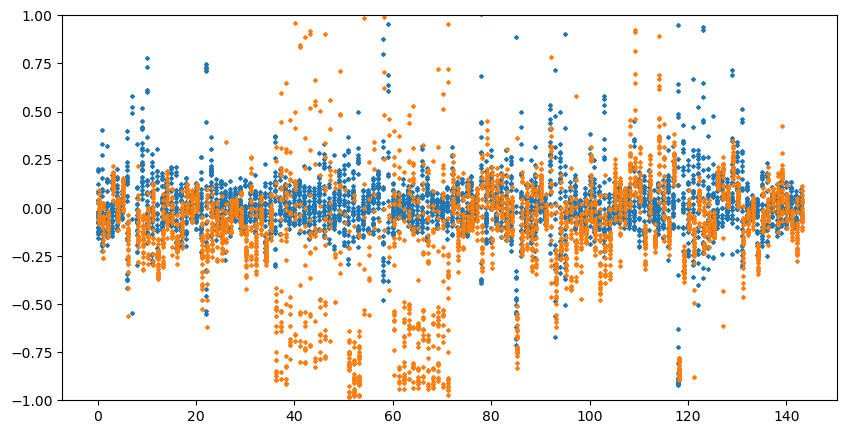

In [9]:
### scatterplot per filename

i_df = c_df.copy()

####substitute filenames for numbers
filename_dict = {}
counter=0
offset=0.2
for filename in list(i_df["filename"].unique()):
    filename_dict[filename]=counter
    counter+=1
i_df["filename_int"]=i_df.apply(lambda x: filename_dict[x["filename"]],axis=1)

fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(i_df["filename_int"],i_df["gaba_conc_cr_acc_rel_error"],s=2)
ax.scatter(i_df["filename_int"]+offset,i_df["gaba_conc_cr_model_rel_error"],s=2)

ax.set_ylim(-1,1)

plt.show()

In [ ]:
## bland altman plot
i_df = c_df[""]


fig,ax = plt.subplots(1,2,figsize=(10,5))




In [3]:
### acc

i_df = acc_df.copy()

i_df = pd.merge(i_df,ref_df,on="filename",suffixes=("_acc","_ref"))

metric = "gaba_conc_cr"
i_df["abs_diff_mean"] = abs(i_df[f"{metric}_acc"] - i_df[f"{metric}_ref"])
i_df["ref"] = i_df[f"{metric}_ref"]
i_df["mean"] = i_df[f"{metric}_acc"]
i_df["std"] = i_df[f"{metric}_acc"]
a_df = i_df.groupby("filename").agg({"ref":"mean","mean":"mean","std":"std","abs_diff_mean":"mean"})
print(a_df.median())

ref              0.111488
mean             0.112855
std              0.010291
abs_diff_mean    0.008638
dtype: float64


In [5]:
### model

i_df = df.copy()

i_df = pd.merge(i_df,ref_df,on="filename",suffixes=("_model","_ref"))

metric = "gaba_conc_cr"
i_df["abs_diff_mean"] = abs(i_df[f"{metric}_model"] - i_df[f"{metric}_ref"])
i_df["ref"] = i_df[f"{metric}_ref"]
i_df["mean"] = i_df[f"{metric}_model"]
i_df["std"] = i_df[f"{metric}_model"]
a_df = i_df.groupby("filename").agg({"ref":"mean","mean":"mean","std":"std","abs_diff_mean":"mean"})
print(a_df.median())

ref              0.114098
mean             0.106700
std              0.035744
abs_diff_mean    0.045391
dtype: float64


   filename  abs_diff_mean_mod  abs_diff_mean_acc
25  p10_s02           0.899511           1.306358
30   p4_s01           0.829886           0.009087
43   p8_s02           0.668308           0.004648
44   p8_s03           0.626525           0.004480
24  p10_s01           0.606793           0.004192
..      ...                ...                ...
46   p8_s11           0.005001           0.002252
47   p8_s12           0.004809           0.003235
45   p8_s10           0.004469           0.005820
10   g5_s11           0.003944           0.005558
58   s3_s11           0.003060           0.003381

[72 rows x 3 columns]


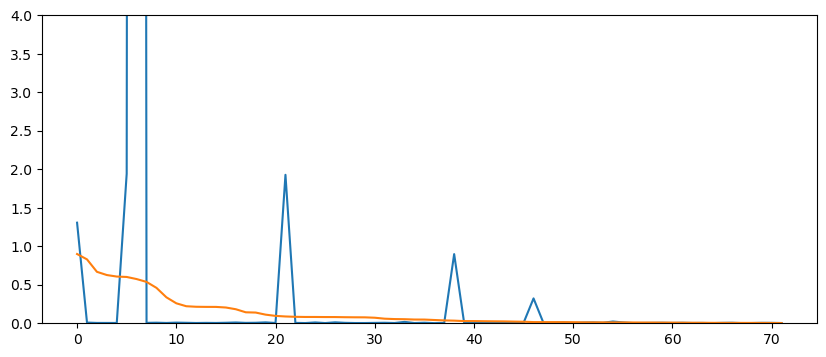

In [13]:
### acc

i_acc_df = acc_df.copy()

i_acc_df = pd.merge(i_acc_df,ref_df,on="filename",suffixes=("_acc","_ref"))

metric = "gaba_conc_cr"
calc="mean"

i_acc_df["abs_diff_mean"] = abs(i_acc_df[f"{metric}_acc"] - i_acc_df[f"{metric}_ref"])
out_acc_df = i_acc_df.groupby("filename").agg({"abs_diff_mean":"std"}).reset_index()

i_mod_df = df.copy()

i_mod_df = pd.merge(i_mod_df,ref_df,on="filename",suffixes=("_acc","_ref"))

i_mod_df["abs_diff_mean"] = abs(i_mod_df[f"{metric}_acc"] - i_mod_df[f"{metric}_ref"])
out_mod_df = i_mod_df.groupby("filename").agg({"abs_diff_mean":"mean"}).reset_index()


out_df = pd.merge(out_mod_df,out_acc_df,on="filename",suffixes=("_mod","_acc"))
out_df = out_df.sort_values("abs_diff_mean_mod",ascending=False)

print(out_df)
fig,ax = plt.subplots(figsize=(10,4))

acc_v = out_df["abs_diff_mean_acc"].values
mod_v = out_df["abs_diff_mean_mod"].values

ax.plot(np.arange(acc_v.shape[0]),acc_v,label="acc")
ax.plot(np.arange(mod_v.shape[0]),mod_v,label="model")

ax.set_ylim(0,4)

plt.show()



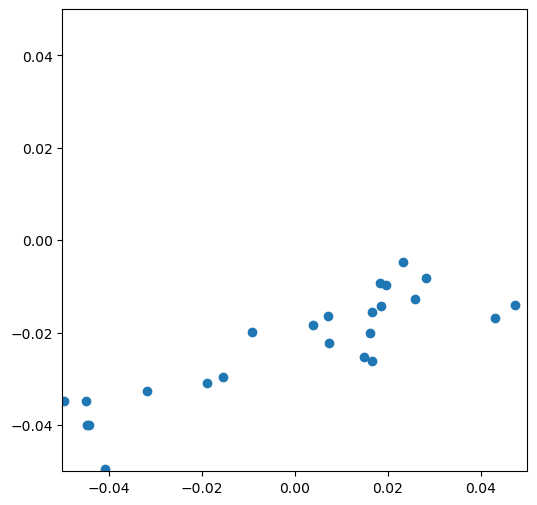

In [15]:


idx = 6
filter_filename = list(df["filename"].unique())[idx]
metric = "gaba_conc_cr"


i_acc_df = acc_df[acc_df["filename"]==filter_filename].copy()
i_acc_df = pd.merge(i_acc_df,ref_df,on="filename",suffixes=("_acc","_ref"))
i_acc_df["error"] = i_acc_df[f"{metric}_acc"] - i_acc_df[f"{metric}_ref"]

i_mod_df = df[df["filename"]==filter_filename].copy()
i_mod_df = pd.merge(i_mod_df,ref_df,on="filename",suffixes=("_acc","_ref"))
i_mod_df["error"] = i_mod_df[f"{metric}_acc"] - i_mod_df[f"{metric}_ref"]

#print(i_acc_df)
#print(i_mod_df)

out_df = pd.merge(i_acc_df,i_mod_df,on=["filename","range"],suffixes=("_acc","_model"))
#print(out_df)

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(out_df["error_acc"],out_df["error_model"])
bound=0.05
ax.set_xlim(-bound,bound)
ax.set_ylim(-bound,bound)
plt.show()

In [3]:
for i in range(21,22):
    idx = i
    filter_filename = list(df["filename"].unique())[idx]
    metric = "gaba_conc_cr"

    print(filter_filename)
    i_acc_df = acc_df[acc_df["filename"]==filter_filename].copy()
    i_acc_df = pd.merge(i_acc_df,ref_df,on="filename",suffixes=("_acc","_ref"))
    i_acc_df["error"] = i_acc_df[f"{metric}_acc"] - i_acc_df[f"{metric}_ref"]
    i_acc_df["abs_error"] = abs(i_acc_df["error"])

    i_mod_df = df[df["filename"]==filter_filename].copy()
    i_mod_df = pd.merge(i_mod_df,ref_df,on="filename",suffixes=("_acc","_ref"))
    i_mod_df["error"] = i_mod_df[f"{metric}_acc"] - i_mod_df[f"{metric}_ref"]
    i_mod_df["abs_error"] = abs(i_mod_df["error"])

    out_df = pd.merge(i_acc_df,i_mod_df,on=["filename","range"],suffixes=("_acc","_model"))

    print(f"Range => Model: {i_mod_df['error'].max()-i_mod_df['error'].min()} | Acc: {i_acc_df['error'].max()-i_acc_df['error'].min()}")
    print(f"Mean Error => Model: {i_mod_df['error'].mean()} | Acc: {i_acc_df['error'].mean()}")
    print(f"Std Error => Model: {i_mod_df['error'].std()} | Acc: {i_acc_df['error'].std()}")
    print(f"Mean Abs Error => Model: {i_mod_df['abs_error'].mean()} | Acc: {i_acc_df['abs_error'].mean()}")
    print("--------------------------")

p10_s10
Range => Model: 0.0406967178243166 | Acc: 0.042397521842718694
Mean Error => Model: -0.02205879353143812 | Acc: -0.0001306675452998207
Std Error => Model: 0.010616204061252613 | Acc: 0.010814397419758575
Mean Abs Error => Model: 0.02205879353143812 | Acc: 0.008303985260481322
--------------------------


In [16]:
#### g_df

outlier_std_tresh=3
pre_g_df=[]

for i in range(36):
    idx = i
    filter_filename = list(df["filename"].unique())[idx]
    metric = "gaba_conc_cr"

    #print(filter_filename)
    i_acc_df = acc_df[acc_df["filename"]==filter_filename].copy()
    i_acc_df = pd.merge(i_acc_df,ref_df,on="filename",suffixes=("_acc","_ref"))
    i_acc_df["error"] = i_acc_df[f"{metric}_acc"] - i_acc_df[f"{metric}_ref"]
    i_acc_df["abs_error"] = abs(i_acc_df["error"])

    i_mod_df = df[df["filename"]==filter_filename].copy()
    i_mod_df = pd.merge(i_mod_df,ref_df,on="filename",suffixes=("_acc","_ref"))
    i_mod_df["error"] = i_mod_df[f"{metric}_acc"] - i_mod_df[f"{metric}_ref"]
    i_mod_df["abs_error"] = abs(i_mod_df["error"])

    out_df = pd.merge(i_acc_df,i_mod_df,on=["filename","range"],suffixes=("_acc","_model"))

    model_error=i_mod_df['error'].values
    model_abs_error=i_mod_df['abs_error'].values

    model_mean = model_error.mean()
    model_median = i_mod_df['error'].median()
    model_std = model_error.std()

    model_low_bound = model_median-outlier_std_tresh*model_std
    model_high_bound = model_median+outlier_std_tresh*model_std

    model_outliers = np.argwhere((model_error>model_high_bound)|(model_error<model_low_bound)).shape[0]

    acc_error=i_acc_df['error'].values
    acc_abs_error=i_acc_df['abs_error'].values

    acc_mean = acc_error.mean()
    acc_median = i_acc_df['error'].median()
    acc_std = acc_error.std()

    acc_low_bound = acc_median-outlier_std_tresh*acc_std
    acc_high_bound = acc_median+outlier_std_tresh*acc_std

    acc_outliers = np.argwhere((acc_error>acc_high_bound)|(acc_error<acc_low_bound)).shape[0]

    #ranking
    model_closer = out_df[out_df["abs_error_model"]<out_df["abs_error_acc"]].shape[0]
    acc_closer = out_df[out_df["abs_error_acc"]<out_df["abs_error_model"]].shape[0]

    row_pre_g_df = {
        "filename":filter_filename,
        "model_range":i_mod_df['error'].max()-i_mod_df['error'].min(),
        "acc_range":i_acc_df['error'].max()-i_acc_df['error'].min(),
        "model_mean_error":model_mean,
        "model_std_error":model_std,
        "model_abs_error":model_abs_error.mean(),
        "model_outliers":model_outliers,
        "model_closer":model_closer,
        "acc_mean_error":acc_mean,
        "acc_std_error":acc_std,
        "acc_abs_error":acc_abs_error.mean(),
        "acc_outliers":acc_outliers,
        "acc_closer":acc_closer

    }
    pre_g_df.append(row_pre_g_df)

In [17]:
g_df = pd.DataFrame(pre_g_df)

In [34]:
g_df.mean()

C:\Users\rodrigo\AppData\Local\Temp\ipykernel_14128\181238426.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  g_df.mean()


model_range          0.069794
acc_range           14.784874
model_mean_error     0.008402
model_std_error      0.015925
model_abs_error      0.029835
model_outliers       0.111111
model_closer        10.888889
acc_mean_error      -0.845611
acc_std_error        3.151258
acc_abs_error        0.926179
acc_outliers         0.138889
acc_closer          14.111111
dtype: float64

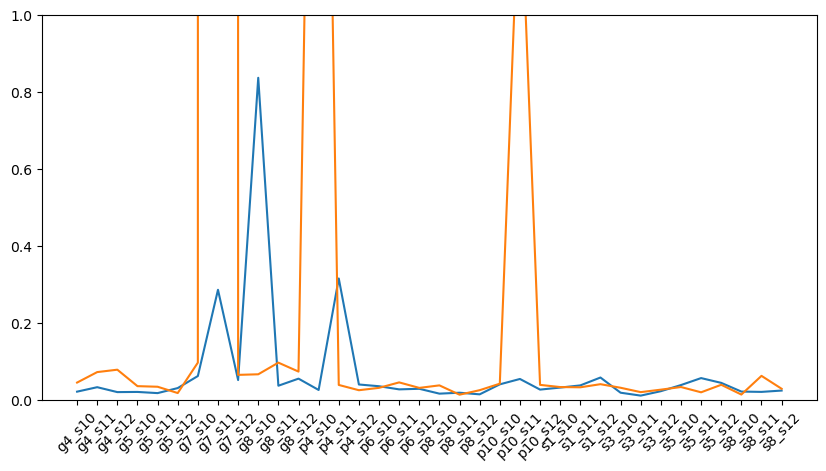

In [27]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(g_df["filename"],g_df["model_range"],label="model_range")
ax.plot(g_df["filename"],g_df["acc_range"],label="acc_range")

ax.set_ylim(0,1)
plt.xticks(rotation=45)

plt.show()

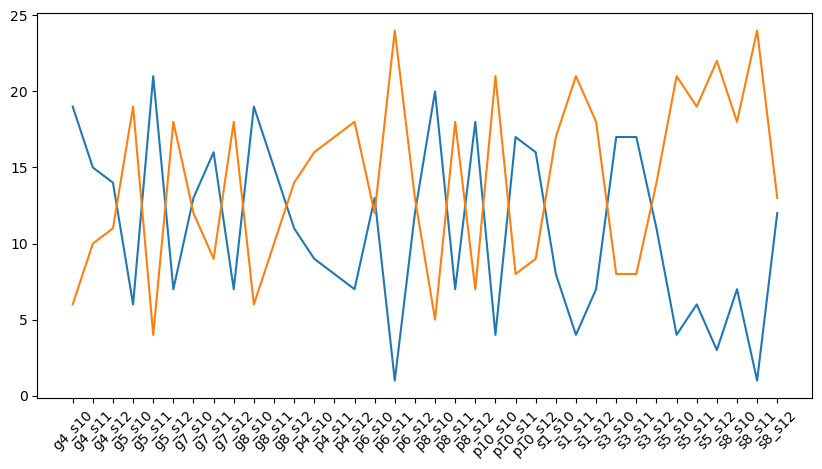

In [33]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(g_df["filename"],g_df["model_closer"],label="model_mean")
ax.plot(g_df["filename"],g_df["acc_closer"],label="acc_mean")

#ax.set_ylim(0,0.1)
plt.xticks(rotation=45)

plt.show()

C:\Users\rodrigo\AppData\Local\Temp\ipykernel_14128\181238426.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  g_df.mean()


model_range          0.069794
acc_range           14.784874
model_mean_error     0.008402
model_std_error      0.015925
model_abs_error      0.029835
model_outliers       0.111111
model_closer        10.888889
acc_mean_error      -0.845611
acc_std_error        3.151258
acc_abs_error        0.926179
acc_outliers         0.138889
acc_closer          14.111111
dtype: float64